Using pdf from Matt:
```
@article{Alberty1998Jun,
	author = {Alberty, Jochen and Carstensen, Carsten and Funken, Stefan A.},
	title = {{Remarks Around 50 Lines Of Matlab: Short Finite Element Implementation}},
	journal = {Numerical Algorithms},
	volume = {20},
	number = {2-3},
	year = {1998},
	month = {Jun},
	issn = {1017-1398},
	doi = {10.1023/A:1019155918070}
}
```

And tutorial <https://www.particleincell.com/2012/matlab-fem/>

In [1]:
from mesh import Mesh
import numpy as np
import triangle as tr
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Mesh Generation

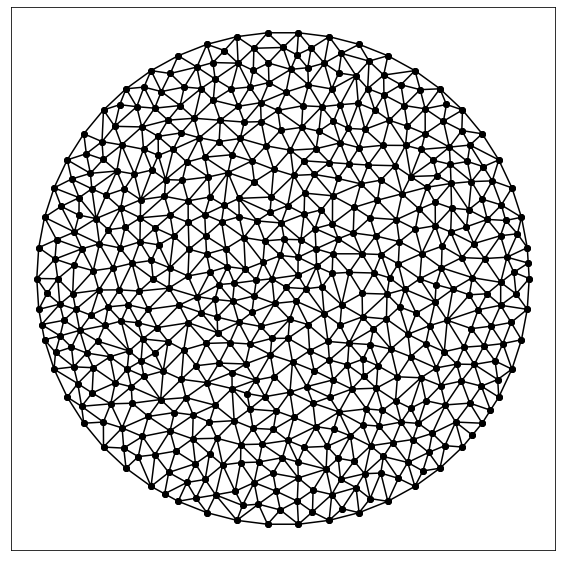

In [2]:
# Create mesh
mesh = Mesh(50, min_size=0.005, min_angle=22)

# Plot mesh
fig, axis = plt.subplots(figsize=(10,10))
tr.plot(axis, **(mesh.triangulation))
plt.show()

# Plotting on Mesh

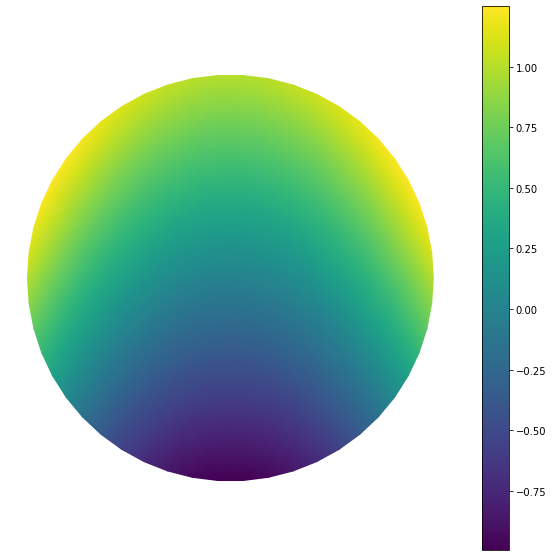

In [3]:
soln = [x**2 + y for [x,y] in mesh.triangulation['vertices']]
fig, axis = plt.subplots(figsize=(10,10))
mesh.plot(soln, axis)

# Solving the Poisson Equation

- PDE: $-\nabla^2 u = f(x,y)$
- Body force: $f(x,y) = 4$
- Dirichlet boundary: $u_{boundary} = 0$.
- Analytical solution: $u(x,y) = 1 - (x^2 + y^2)$

Text(0.5, 1.0, 'Error')

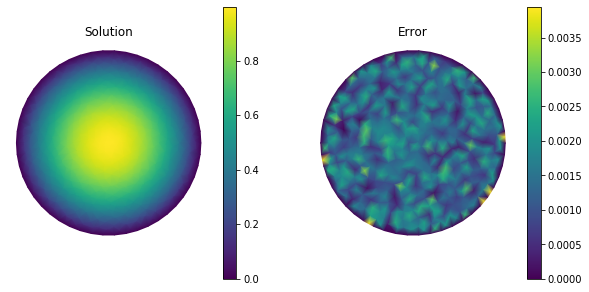

In [4]:
def calculate_body_force(vertex):
    # Body force is simply f=4
    return 4

def analytical_solution(vertex):
    return 1.0 - vertex[0]**2 - vertex[1]**2

stiffness = mesh.assemble_stiffness()
force_vector = mesh.assemble_body_force(calculate_body_force)

# Apply boundary conditions
stiffness[mesh.boundary_vertices,:] = 0.0
stiffness[:,mesh.boundary_vertices] = 0.0
for vertex in mesh.boundary_vertices:
    stiffness[vertex, vertex] = 1.0
force_vector[mesh.boundary_vertices] = 0.0

# Solve
rhs_vector = force_vector
soln = np.linalg.solve(stiffness, rhs_vector)

# Calculate error
error = [
    abs(soln[i] - analytical_solution(vertex))
    for i, vertex in enumerate(mesh.vertices())]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10,5))
mesh.plot(soln, axes[0])
axes[0].set_title('Solution')
mesh.plot(error, axes[1])
axes[1].set_title(r'Error')

# Solving the Laplace Equation

- PDE: $\nabla^2 u = 0$
- Dirichlet boundary: $u(\theta) = \sin(3\theta)$
- Analytical solution: $u(r,\theta) = r^3 \sin(3\theta)$

Text(0.5, 1.0, 'Error')

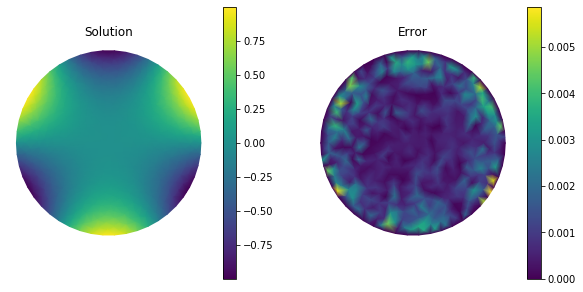

In [5]:
def theta_from_vertex(p):
    return np.arctan2(p[1], p[0])

def calculate_dirichlet_value(vertex):
    return math.sin(3*theta_from_vertex(vertex))

def analytical_solution(x, y):
    r = math.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r**3 * math.sin(3*theta)

stiffness = mesh.assemble_stiffness()

# Apply boundary conditions
# Remove boundary points from stiffness
stiffness[mesh.boundary_vertices,:] = 0.0
# And ensure matrix isn't singular
for vertex in mesh.boundary_vertices:
    stiffness[vertex, vertex] = 1.0

# Generate RHS vector
rhs_vector = np.zeros(mesh.n_vertices)
# Insert boundary conditions i.e. known nodes
rhs_vector[mesh.boundary_vertices] = mesh.calculate_boundary_values(calculate_dirichlet_value)

# Solve
soln = np.linalg.solve(stiffness, rhs_vector)

# Calculate error
error = [
    abs(soln[i] - analytical_solution(vertex[0], vertex[1]))
    for i, vertex in enumerate(mesh.vertices())]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10,5))
mesh.plot(soln, axes[0])
axes[0].set_title('Solution')
mesh.plot(error, axes[1])
axes[1].set_title(r'Error')

# Heat Equation

- Explicit time-stepping
- PDE: $\frac{\partial u} {\partial t} = \nabla^2 u + f$
- body force: $f(x,y) = 4$
- Dirichlet boundary: $u_{boundary} = 0$
- Initial state: $u=0$

Text(0.5, 1.0, 'Error')

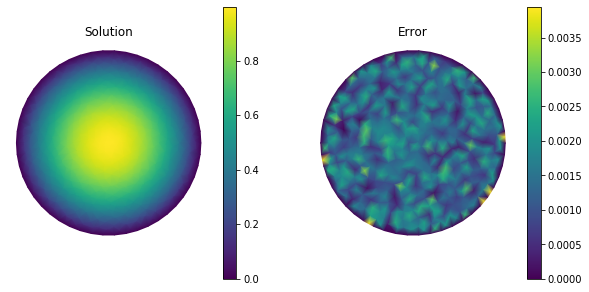

In [20]:
def calculate_body_force(vertex):
    # Body force is simply f=4
    return 4

dt = 0.1
T = 10.0
t = 0.0

# Initial conditions
u_prev = np.zeros(mesh.n_vertices)

# Assemble matrices & body force
stiffness = mesh.assemble_stiffness()
mass = mesh.assemble_mass()
force_vector = mesh.assemble_body_force(calculate_body_force)

# Apply boundary conditions
stiffness[mesh.boundary_vertices,:] = 0.0
stiffness[:,mesh.boundary_vertices] = 0.0
for vertex in mesh.boundary_vertices:
    stiffness[vertex, vertex] = 1.0
force_vector[mesh.boundary_vertices] = 0.0

# Solve
lhs_matrix = dt*stiffness + mass

while t<T:
    rhs_vector = dt*force_vector + mass.dot(u_prev)
    u_next = np.linalg.solve(lhs_matrix, rhs_vector)
    u_prev[:] = u_next[:]
    t+=dt

soln = u_next

# Calculate error
error = [
    abs(soln[i] - (1.0 - vertex[0]**2 - vertex[1]**2))
    for i, vertex in enumerate(mesh.vertices())]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10,5))
mesh.plot(soln, axes[0])
axes[0].set_title('Solution')
mesh.plot(error, axes[1])
axes[1].set_title(r'Error')

In [7]:
def is_von_neumman(interp):
    return interp < 0.5

def von_neumann_bc_value(interp):
    return 0
#     return 0.1*np.sin(2*np.pi*interp)

def calculate_von_neumann_bc(mesh):
    bc_vector = np.zeros(mesh.n_vertices)
    for vertex in mesh.boundary_vertices:
        if is_von_neumman(mesh.get_interp(vertex)):
            bc_vector[vertex] = 0.5*von_neumann_bc_value(mesh.get_interp(vertex))    
    return bc_vector